In [1]:
import os
print(os.getcwd())
os.chdir('/home/vco/Projects/dcr-to-tapn')
print(os.getcwd())

/home/vco/Projects/dcr-to-tapn/notebook
/home/vco/Projects/dcr-to-tapn


In [2]:
import pm4py
from pm4py.objects.petri_net.utils import reachability_graph
from pm4py.visualization.transition_system import visualizer as ts_visualizer
from pm4py.objects.petri_net.transport_invariant import semantics as tapn_semantics

import pandas as pd

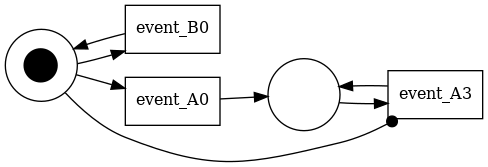

In [3]:
tapn, m, fm = pm4py.read_tapn('models/all/rel_excludesTo_responseTo_A100_B100.tapn')
t = tapn.get_transition_by_id("event_A0")
m2 = tapn_semantics.execute(t,tapn,m)

pm4py.view_petri_net(tapn,m,fm,format="png",bgcolor="white")

<class 'pm4py.objects.petri_net.obj.Marking'>


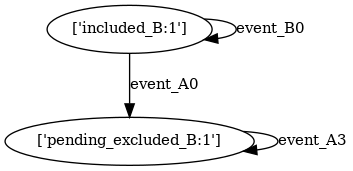

In [10]:
trans_sys = reachability_graph.construct_reachability_graph(tapn, m, use_trans_name=True,
                                                            parameters={'petri_semantics': tapn_semantics.TransportInvariantSemantics() ,'max_elab_time': 2*60})
gviz = ts_visualizer.apply(trans_sys, parameters={ts_visualizer.Variants.VIEW_BASED.value.Parameters.FORMAT: "png","bgcolor":"white"})
ts_visualizer.view(gviz)

# Sketch of optimization
Given a rule or exception + marking do:
    - Take the reachability graph for that rule/exception in isolation.
    - Find the reachable transitions and changing places.
    - Keep only those
Given A -> B -> C and we are mapping B -> C. Check all posibilities of A for a B and use those as starting points for the reachability.


# Analysis for paper

In [3]:
from pm4py.objects.petri_net.importer import importer as pnml_importer
from pm4py.objects.dcr.importer import importer as dcr_importer
import os
from pathlib import Path

allowed_versions = ['fulloptimization','pnreachability','dcranalysis','unoptimized']

def count_dcr_relations(dcr):
    res = 0
    for e in dcr['events']:
        for e_prime in dcr['events']:
            for rel in ['conditionsFor','responseTo','includesTo','excludesTo']:
                if e in dcr[rel] and e_prime in dcr[rel][e]:
                    res = res + 1
    return res

def run_analysis_on_pnmls(datasets_folder):

    pnml_res = []
    dcrxml_res = {}

    for root, dirs, files in os.walk(datasets_folder):
        for file in files:
            if file.endswith(".pnml"):
                pnml_res.append(os.path.join(root, file))
            if file.endswith(".dcrxml"):
                dcrxml_res[Path(file).stem] = os.path.join(root, file)

    analysis_results = {}
    for pnml in pnml_res:
        path_without_extension = os.path.splitext(pnml)[0]
        name_with_extension = os.path.basename(pnml)
        name = Path(pnml).stem
        version = name.split('_')[-1]
        dcr_file = dcrxml_res[name.replace(f'_{version}','')]
        # analysis
        if version in allowed_versions:
            tapn,_,_ = pnml_importer.apply(pnml)

            dcr = dcr_importer.apply(dcr_file)
            dcr_rels = count_dcr_relations(dcr)

            analysis_results[name] = {}
            analysis_results[name]['version'] = version
            analysis_results[name]['#places'] = len(tapn.places)
            analysis_results[name]['#transitions'] = len(tapn.transitions)
            analysis_results[name]['#arcs'] = len(tapn.arcs)
            analysis_results[name]['#dcrevents'] = len(dcr['events'])
            analysis_results[name]['#dcrrelations'] = dcr_rels
    df = pd.DataFrame(analysis_results).T
    df.to_csv('models/analysis/optimization_analysis.csv')

In [5]:
run_analysis_on_pnmls('/home/vco/Datasets/')

## DCR vs the rest

In [14]:
df_opt_analysis = pd.read_csv('models/analysis/optimization_analysis.csv',index_col=0)
df_opt_analysis = df_opt_analysis.reset_index()
df_opt_analysis = df_opt_analysis.rename({'index':'dataset'},axis=1)
df_opt_analysis['dataset']=df_opt_analysis['dataset'].str.replace('_fulloptimization','')
df_opt_analysis['dataset']=df_opt_analysis['dataset'].str.replace('_dcranalysis','')
df_opt_analysis['dataset']=df_opt_analysis['dataset'].str.replace('_pnreachability','')
df_opt_analysis['dataset']=df_opt_analysis['dataset'].str.replace('_unoptimized','')

### Only look at all four mappings

In [ ]:
no_of_mappings = df_opt_analysis[['dataset','version']].groupby('dataset').count()
all_four = no_of_mappings[no_of_mappings['version']==4].index.to_list()
af_df = df_opt_analysis[df_opt_analysis['dataset'].isin(all_four)]

### Only look at two mappings

In [15]:
af_df = df_opt_analysis

In [16]:
af_df['version'] = af_df['version'].replace({'fulloptimization':'4_fulloptimization', 'dcranalysis':'2_dcranalysis', 'pnreachability':'3_pnreachability', 'unoptimized':'1_unoptimized'})
af_df = af_df.sort_values(['dataset','version']).reset_index(drop=True)
af_df['%events'] = ((af_df['#places']+af_df['#transitions']-af_df['#dcrevents'])*100/af_df['#dcrevents']).round(2)
af_df['%arcs'] = ((af_df['#arcs']-af_df['#dcrrelations'])*100/af_df['#dcrrelations']).round(2)
af_df

,dataset,version,#places,#transitions,#arcs,#dcrevents,#dcrrelations,%events,%arcs
0,12681647,1_unoptimized,68,612,7216,17,25,3900.00,28764.00
1,12681647,2_dcranalysis,21,83,481,17,25,511.76,1824.00
2,12681647,3_pnreachability,38,77,752,17,25,576.47,2908.00
3,12681647,4_fulloptimization,21,65,361,17,25,405.88,1344.00
4,BPI Challenge 2017 - Offer log,2_dcranalysis,15,152,1374,8,29,1987.50,4637.93
...,...,...,...,...,...,...,...,...,...
91,pcc_a5_L2,2_dcranalysis,4,11,54,3,5,400.00,980.00
92,pcc_a5_L2,3_pnreachability,6,5,27,3,5,266.67,440.00
93,pcc_a5_L2,4_fulloptimization,4,4,19,3,5,166.67,280.00
94,review_example_large,2_dcranalysis,32,25233,729198,14,61,180364.29,1195306.56


In [17]:
af_df[af_df['#transitions']>0][['version','%events','%arcs']].groupby('version').describe()

%events                                                 \
                     count          mean            std     min       25%   
version                                                                     
1_unoptimized         19.0  49191.657368  139544.433514  700.00  2300.000   
2_dcranalysis         31.0  55919.144839  126360.442227  100.00  1049.600   
3_pnreachability      13.0    312.370769     177.666325   80.00   200.000   
4_fulloptimization    20.0    243.788500     148.480059   64.29   146.875   

                                                   %arcs                 \
                        50%         75%        max count           mean   
version                                                                   
1_unoptimized       7241.18  49500.0000  619200.00  19.0  227765.043158   
2_dcranalysis       6528.57  18425.0000  602937.50  31.0  243534.202903   
3_pnreachability     242.86    359.2600     676.47  13.0     979.720769   
4_fulloptimization   212.50    278.5725     711.76  20.0     497.375000   

                                                                             \
                              std      min       25%       50%          75%   
version                                                                       
1_unoptimized       688633.828480  1500.00  9450.000  48323.53  191195.2650   
2_dcranalysis       521668.795810     0.00  3336.765  22404.00   63143.7500   
3_pnreachability      1229.514683     6.67   200.000    312.00    1516.6700   
4_fulloptimization     646.743218     0.00   112.930    278.00     595.3425   

                                
                           max  
version                         
1_unoptimized       3053333.77  
2_dcranalysis       2265180.22  
3_pnreachability       3197.06  
4_fulloptimization     2685.11

## Unoptimized vs the rest

In [8]:
unop_vs = af_df[['dataset','version','#places','#transitions','#arcs']]
unops_only = unop_vs[unop_vs['version']=='1_unoptimized'][['dataset','#places','#transitions','#arcs']].rename({'#places':'#unop_places','#transitions':'#unop_transitions','#arcs':'#unop_arcs'},axis=1)
unop_vs = unop_vs.merge(unops_only,on='dataset',how="left")
unop_vs['delta_places'] = unop_vs['#places']-unop_vs['#unop_places']
unop_vs['delta_transitions'] = unop_vs['#transitions']-unop_vs['#unop_transitions']
unop_vs['delta_arcs'] = unop_vs['#arcs']-unop_vs['#unop_arcs']
unop_vs['%delta_places'] = ((unop_vs['#unop_places']-unop_vs['#places'])*100/unop_vs['#places']).round(2)
unop_vs['%delta_transitions'] = ((unop_vs['#unop_transitions']-unop_vs['#transitions'])*100/unop_vs['#transitions']).round(2)
unop_vs['%delta_arcs'] = ((unop_vs['#unop_arcs']-unop_vs['#arcs'])*100/unop_vs['#arcs']).round(2)
unop_vs

,dataset,version,#places,#transitions,#arcs,#unop_places,#unop_transitions,#unop_arcs,delta_places,delta_transitions,delta_arcs,%delta_places,%delta_transitions,%delta_arcs
0,12681647,1_unoptimized,68,612,7216,68,612,7216,0,0,0,0.00,0.00,0.00
1,12681647,2_dcranalysis,21,83,481,68,612,7216,-47,-529,-6735,223.81,637.35,1400.21
2,12681647,3_pnreachability,38,77,752,68,612,7216,-30,-535,-6464,78.95,694.81,859.57
3,12681647,4_fulloptimization,21,65,361,68,612,7216,-47,-547,-6855,223.81,841.54,1898.89
4,BPI_Challenge_2013_closed_problems,1_unoptimized,16,52,412,16,52,412,0,0,0,0.00,0.00,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
67,pcc_a2_L,4_fulloptimization,3,2,9,8,28,216,-5,-26,-207,166.67,1300.00,2300.00
68,pcc_a5_L2,1_unoptimized,12,64,536,12,64,536,0,0,0,0.00,0.00,0.00
69,pcc_a5_L2,2_dcranalysis,4,11,54,12,64,536,-8,-53,-482,200.00,481.82,892.59
70,pcc_a5_L2,3_pnreachability,6,5,27,12,64,536,-6,-59,-509,100.00,1180.00,1885.19


In [11]:
unop_vs[unop_vs['#transitions']>0][['version','%delta_places','%delta_transitions','%delta_arcs']].groupby('version').describe()

%delta_places                                          \
                           count        mean         std     min     25%   
version                                                                    
1_unoptimized               18.0    0.000000    0.000000    0.00    0.00   
2_dcranalysis               18.0  135.227222  113.794093   33.33   33.33   
3_pnreachability            13.0  112.910000   34.529487   71.43   78.95   
4_fulloptimization          13.0  217.890769   90.577312  100.00  175.00   

                                              %delta_transitions               \
                        50%       75%     max              count         mean   
version                                                                         
1_unoptimized         0.000    0.0000    0.00               18.0     0.000000   
2_dcranalysis       103.335  198.9125  433.33               18.0   299.111667   
3_pnreachability    100.000  138.2400  185.71               13.0  4150.711538   
4_fulloptimization  195.650  272.4100  433.33               13.0  2547.672308   

                    ...                    %delta_arcs               \
                    ...      75%       max       count         mean   
version             ...                                               
1_unoptimized       ...     0.00      0.00        18.0     0.000000   
2_dcranalysis       ...   472.69    637.35        18.0   622.193333   
3_pnreachability    ...  2433.33  29900.00        13.0  6727.478462   
4_fulloptimization  ...  2950.00   9972.73        13.0  4900.700000   

                                                                         \
                             std      min      25%       50%        75%   
version                                                                   
1_unoptimized           0.000000     0.00     0.00     0.000     0.0000   
2_dcranalysis         552.237707    19.28   204.67   218.865  1086.5625   
3_pnreachability    13796.529842   232.26  1368.69  1863.640  3500.0000   
4_fulloptimization   5119.879838  1500.00  2203.03  3219.350  3966.6700   

                              
                         max  
version                       
1_unoptimized           0.00  
2_dcranalysis        1616.67  
3_pnreachability    50650.00  
4_fulloptimization  19630.12  

[4 rows x 24 columns]